In [1]:
%load_ext pyinstrument
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

local


In [2]:
#%%pyinstrument
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

(1099, 1)

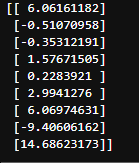

{'main': CompoundNamed(comment='.signal.main')}


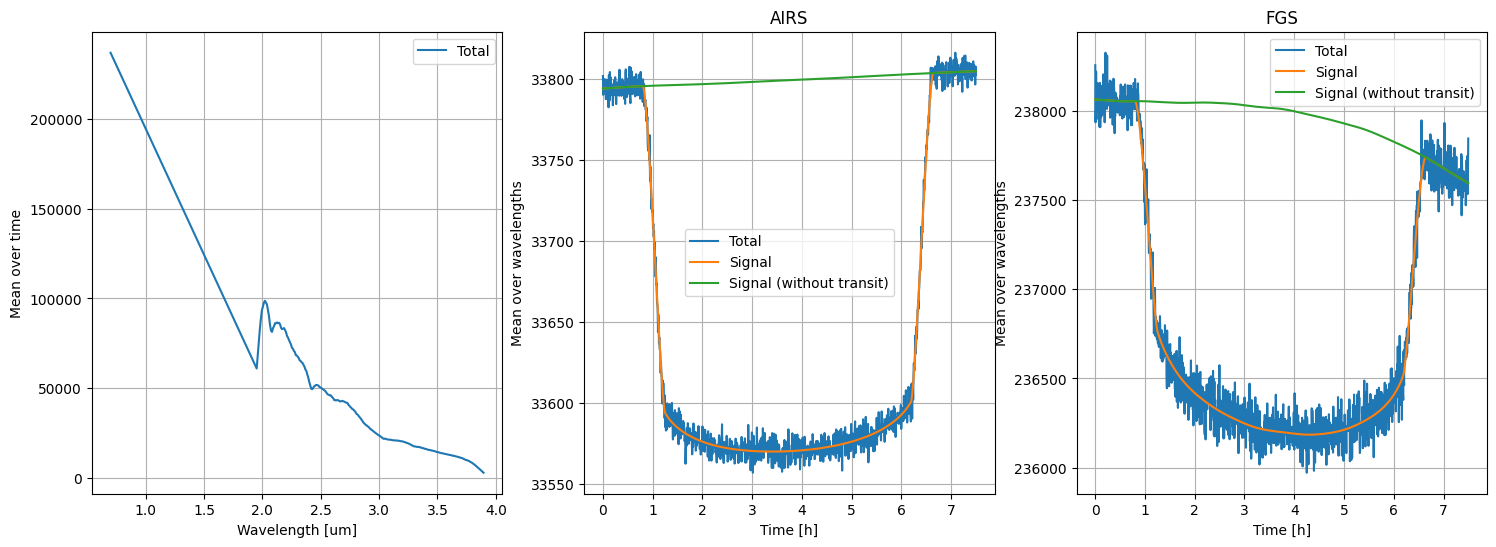

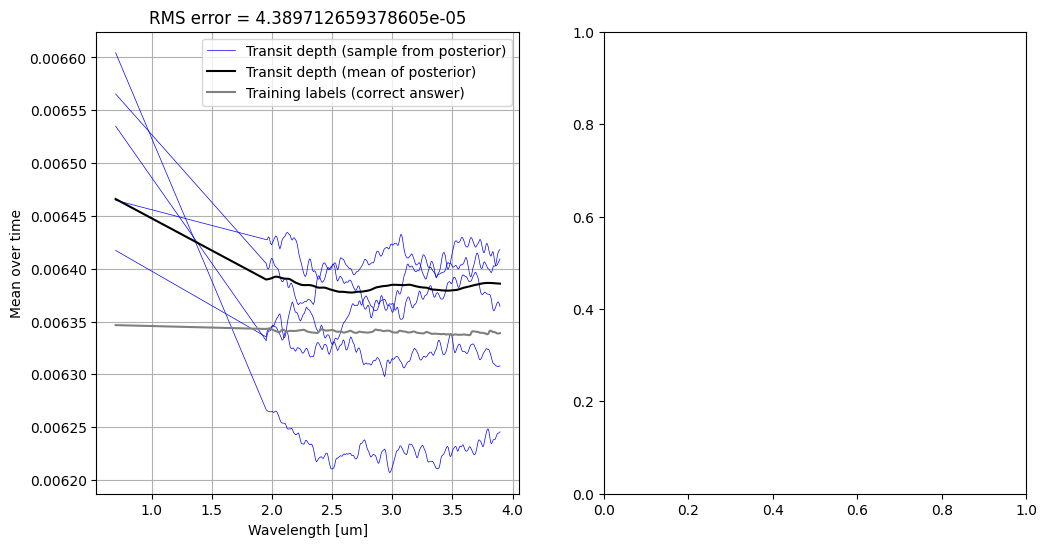

Score:          2.5382
RMS error FGS:  119.39 ppm
RMS error AIRS: 43.40 ppm
Score:          3.7025
RMS error FGS:  141.56 ppm
RMS error AIRS: 29.06 ppm
CPU times: user 21 s, sys: 3.66 s, total: 24.7 s
Wall time: 25.9 s


(3.702544525696337, 0.00014155744414669127, 2.9058556745495113e-05)

In [3]:
%%time
import gp
import ariel_gp
import ariel_load_FGS
importlib.reload(ariel_load_FGS)
importlib.reload(ariel_load)
kgs.profiling=False
kgs.debugging_mode=1
kgs.sanity_checks_active=False
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.use_training_labels = False
model.starter_model.do_plots = False
model.plot_final = True
model.plot_simple = True
model.model_options.include_background = False
model.train(train_data)
#model.starter_model.loaders[0].cache_steps = [5]

for ii in range(2):                
    pass
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
#model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
#model.loaders[0].cache_steps = []
model.starter_model.loaders = model.loaders


loaders = model.starter_model.loaders
#loaders[0].cache_steps= []
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = False
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = False
#loaders[0].apply_wavelength_binning.options.use_sum = True
# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = np.inf
# loaders[1].apply_wavelength_binning.sequential_fit = True


            
#model.loaders[0].cache_steps = [5]
data = [train_data[[d.planet_id for d in train_data].index(1843015807)]] # ingress and egress obscured
1349926825
#data = train_data[1:2]
data = [train_data[[d.planet_id for d in train_data].index(1349926825)]]
data = train_data[1:2]
#data = [train_data[[d.planet_id for d in train_data].index(2270815333)]] # ingress and egress obscured
for d in data:
    d.load_to_step(0,model.loaders)
inferred_data = model.infer(data)
kgs.score_metric(inferred_data, data)
model.starter_model.do_plots = False
inferred_data_simple = model.starter_model.infer(data)
kgs.score_metric(inferred_data_simple, data)

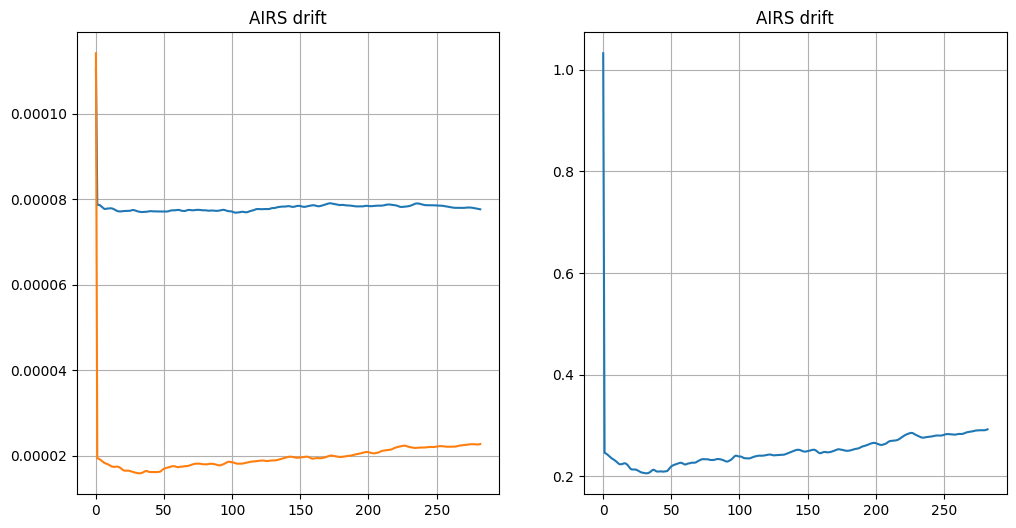

In [6]:
import copy
class Fixer(gp.Passthrough):
    model = None
    param_holder = None
    def _check_constraints(self):
        assert isinstance(self.model, gp.Model)      
        self.model.check_constraints() 
    def initialize(self, obs):
        self.initialized = True
        self.number_of_observations = self.model.number_of_observations
        self.number_of_instances = self.model.number_of_instances
        self.number_of_parameters = self.model.number_of_parameters
        self.param_holder = self.model.get_parameters()
        return
    def get_observation_relationship_internal(self,obs):
        res = super().get_observation_relationship_internal(obs)
        res.design_matrix = gp.sparse_matrix(res.design_matrix.shape)
        res.observable_offset = self.get_prediction(obs)[:,0]
        return res
    def set_parameters_internal(self, to_what):        
        self.number_of_instances = to_what.shape[1]
        self.param_holder = to_what
    def get_parameters_internal(self):
        return self.param_holder
    def get_prediction_internal(self, obs):
        pred = self.model.get_prediction(obs)
        pred = np.tile(pred, (self.number_of_instances,1))
        return pred
    
def make_fixed(m):
    res = Fixer()
    res.model = m
    #print(type(res))
    res.initialize(model.results['obs'])
    res.number_of_observations = m.number_of_observations
    res.number_of_instances = m.number_of_instances
    #print(type(res))
    return res
obs = model.results['obs']
def get_sigma(model_new):
    inds = kgs.ismembertol(kgs.wavelengths,model.results['model_mean'].m['signal'].m['main'].m['transit'].wavelengths)
    inds = np.delete(inds, inds==-1)
    model_new.clear_all_caches()
    a,b,_ = gp.solve_gp(model_new, obs, n_samples=1000, fill_noise_parameters=False, rng=np.random.default_rng(seed=inferred_data[0].planet_id))
    b
    sample_labels = b.m['signal'].m['main'].m['transit'].depth_model.get_prediction(b.m['signal'].m['main'].m['transit'].obs_wavelength)
    pred_labels = a.m['signal'].m['main'].m['transit'].depth_model.get_prediction(a.m['signal'].m['main'].m['transit'].obs_wavelength)
    sample_labels = sample_labels[inds,:]-pred_labels[inds,0][:,np.newaxis]
    cov = (sample_labels@sample_labels.T)/sample_labels.shape[1]
    return np.sqrt(np.diag(cov))
#sigma_old = get_sigma(copy.deepcopy(model.results['model_mean']))#np.sqrt(np.diag(inferred_data[0].spectrum_cov))
for ii in [3]:#range(2):
    model_new = copy.deepcopy(model.results['model_mean'])
    match ii:
        case 0:
            name = 'Baseline'
        case 1:
            name = 'Stellar spectrum'
            mm =  model_new.m['signal'].m['main'].m
            mm['spectrum'] = make_fixed(mm['spectrum'])
            model_new.m['signal'].m['main'].m = mm
        case 2:
            name = 'FGS drift'
            mm =  model_new.m['signal'].m['main'].m['drift'].m
            mm['FGS'] = make_fixed(mm['FGS'])
            model_new.m['signal'].m['main'].m['drift'].m = mm
        case 3:
            name = 'AIRS drift'
            mm =  model_new.m['signal'].m['main'].m['drift'].m
            mm['AIRS'] = make_fixed(mm['AIRS'])
            model_new.m['signal'].m['main'].m['drift'].m = mm
            
    _,ax = plt.subplots(1,2,figsize=(12,6))
    #sigma_old = np.sqrt(np.diag(inferred_data[0].spectrum_cov))
    sigma_new = get_sigma(model_new)
    plt.sca(ax[0])
    plt.grid(True)
    plt.plot(sigma_old)
    plt.plot(sigma_new)
    plt.title(name)
    plt.sca(ax[1])
    plt.grid(True)
    plt.plot(sigma_new/sigma_old)
    plt.title(name)
    plt.pause(0.001)

In [ ]:
%debug